## 简单预处理

### 畸变矫正，用于向模型输入图片时的矫正，效果如下：
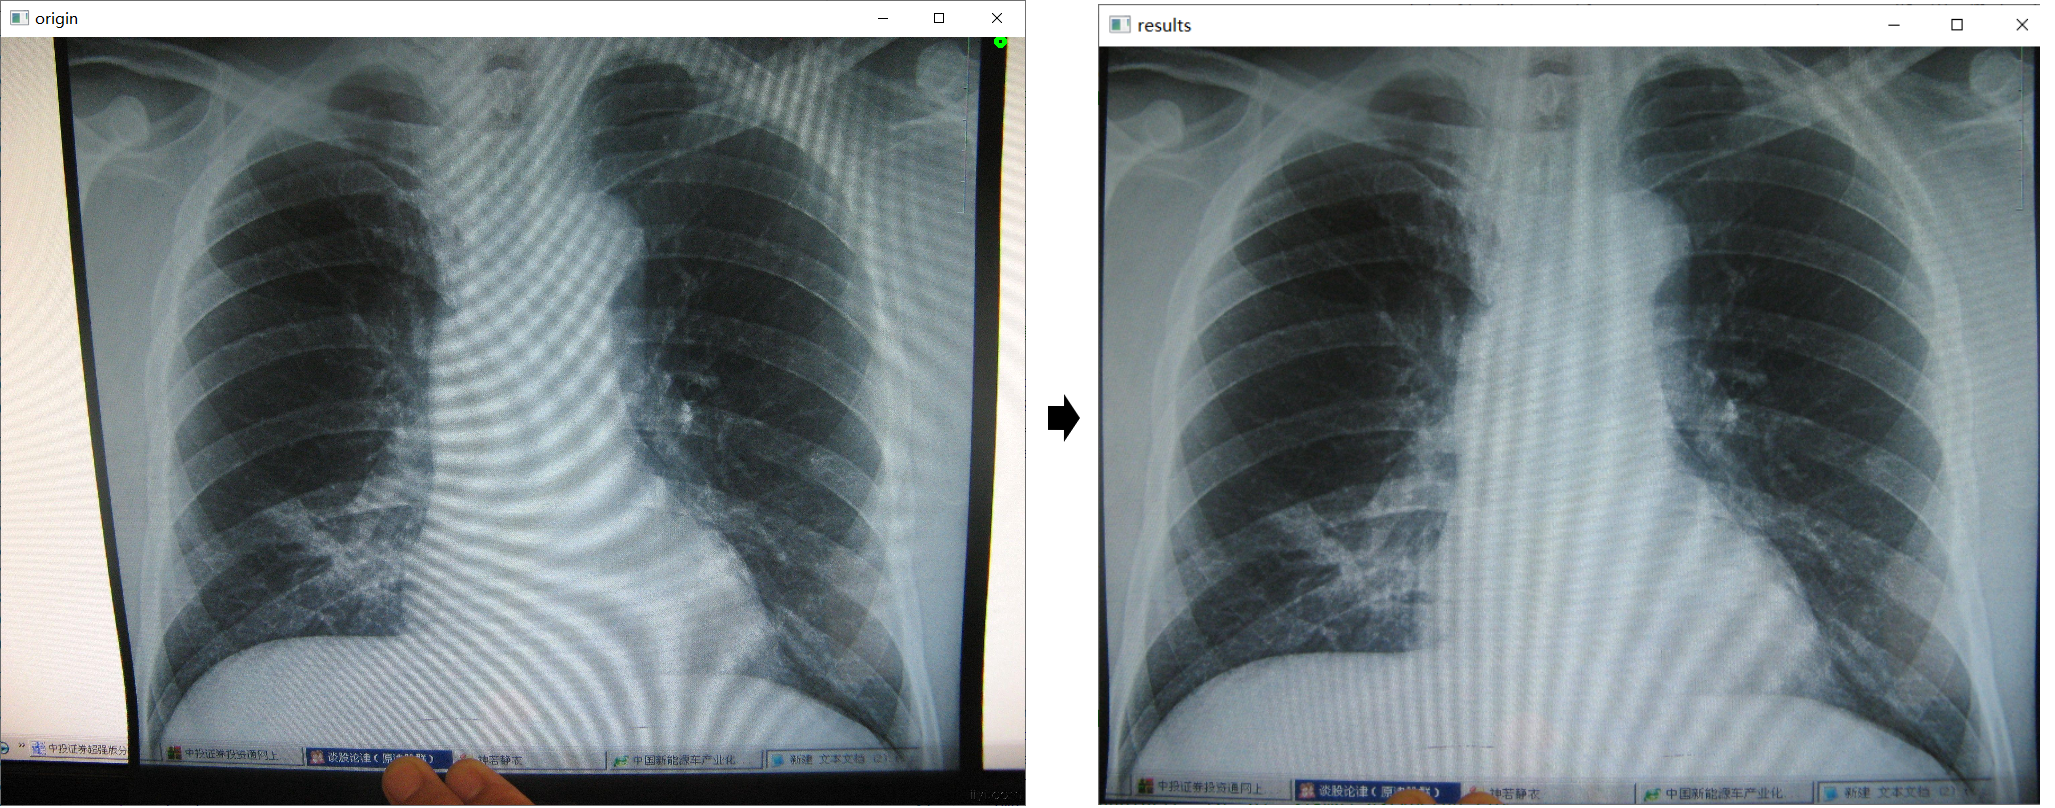

In [1]:
"""
首先顺时针点击需要矫正部分的左上，右上，右下，左下四个角点来对其进行图像矫正；
然后随机点击键盘任意按键得到矫正后的图像；
最后随机点击键盘任意按键退出。
"""
 
import numpy as np
import cv2
 
def order_points(pts):
    
    # 初始化坐标点
    rect = np.zeros((4,2), dtype='float32')
    
    
    # 获取左上角和右下角坐标点
    s = pts.sum(axis=1) # 每行像素值进行相加；若axis=0，每列像素值相加
    rect[0] = pts[np.argmin(s)] # top_left,返回s首个最小值索引，eg.[1,0,2,0],返回值为1
    rect[2] = pts[np.argmax(s)] # bottom_left,返回s首个最大值索引，eg.[1,0,2,0],返回值为2
    
    # 分别计算左上角和右下角的离散差值
    diff = np.diff(pts, axis=1) # 第i+1列减第i列
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect
 
def four_point_transform(image, pts):
 
    # 获取坐标点，并将它们分离开来
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
    # 计算新图片的宽度值，选取水平差值的最大值
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # 计算新图片的高度值，选取垂直差值的最大值
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    # 构建新图片的4个坐标点,左上角为原点
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    # 获取透视变换矩阵并应用它
    M = cv2.getPerspectiveTransform(rect, dst)
    # 进行透视变换
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    # 返回变换后的结果
    return warped
 
 
def on_mouse(event, x, y, flags, param):
    """鼠标在原图像点击，获取矩形的四个边角点坐标"""
    
    global timg, points
    img2 = timg.copy()
    p0 = (0,0) # 初始化
    if event == cv2.EVENT_LBUTTONDOWN:
        p1 = (x,y)
        points.append([x,y])
        print(p1)
        
        # 在点击图像处绘制圆
        # cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(img2, p1, 4, (0,255,0), 4)
        cv2.imshow('origin', img2)
    return p0
 
if __name__ =="__main__":
    global points, timg
    xscale, yscale = 3.0,3.0 # 通过放大图像使点击位置更加精确
    points = []
    img = cv2.imread('./Exjpg/wait.jpg')
    shape = img.shape
    #img=cv2.resize(img, (540,720))
    timg = cv2.resize(img, (int(shape[1]/xscale), int(shape[0]/yscale))) # 放大图像
    print(timg.shape)
    cv2.imshow('origin', timg)
    
    cv2.setMouseCallback('origin', on_mouse) # 此处设置显示的图片名称一定要和上一句以及on_mouse函数中设置的一样
    cv2.waitKey(0) # 四个角点点击完后，随机按键盘结束操作
    cv2.destroyAllWindows()
    
    # 还原像素位置
    points = np.array(points, dtype=np.float32)
    points[:,0] *= shape[1] / int(shape[1]/xscale) 
    points[:,1] *= shape[0] / int(shape[0]/yscale)
    warped = four_point_transform(img, points)
    oshape=warped.shape
    scale=0.3
    wimg=cv2.resize(warped, (int(oshape[1]*scale),int(oshape[0]*scale)))
    cv2.imshow('results', wimg)
    cv2.imwrite('./Exjpg/RESULT_wait.jpg',warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(768, 1024, 3)
(56, 1)
(134, 731)
(972, 732)
(999, 4)


## 直方图匹配

In [ ]:
from skimage.exposure import match_histograms
import cv2
import numpy as np
path1='./18_1.png'  #目标
path2='./17_2.png'  #源
img1=cv2.imread(path1)
img2=cv2.imread(path2)
print(img2.shape)
matched =match_histograms(img2,img1)
print(matched.shape)
#cv2.namedWindow('1',cv2.WINDOW_NORMAL)
cv2.imshow('1',img1)
#cv2.namedWindow('2',cv2.WINDOW_NORMAL)
cv2.imshow('2',img2)
#cv2.namedWindow('match_img12',cv2.WINDOW_NORMAL)
cv2.imshow('match_img12',matched.astype(np.uint8))
cv2.imwrite('17_2++.png',matched.astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()


## 图片操作

In [ ]:
#在大编号后按顺序记录不同的图片
import os
import shutil

folder_B = "E:\\database\\NLMCXR_png"
output_folder = "E:\\database\\extract"
files_B = os.listdir(folder_B)
last='None'
for file_B in files_B:
    
    # 提取 B 文件名中的数字和相关部分
    parts_B = file_B.split("_")
    #print(parts_B)
    prefix_B = parts_B[0][3:]
    if prefix_B==last:
        #print('截断？')
        continue
    count=0
    for file_BB in files_B:
        parts_BB = file_BB.split("_")
        prefix_BB = parts_BB[0][3:]
        if prefix_B == prefix_BB:
            count+=1
            new_file_name = prefix_B +'_'+ str(count)+'.png'
            src_file = os.path.join(folder_B)+'\\'+file_BB
            dst_file = os.path.join(output_folder, new_file_name)
            #print(src_file,dst_file)
            shutil.copy(src_file, dst_file)
    #print('一个内循环！')
    last = prefix_B

## 标签操作

In [ ]:
#从images2(final)里提取存在的图片编号，并从reports里把需要用的xml文件提取出来
import os
import shutil

folder_A = "E:\\database\\images2"
folder_B = "E:\\database\\NLMCXR_reports\\ecgen-radiology"
output_folder = "E:\\database\\reports"

files_A = os.listdir(folder_A)
files_B = os.listdir(folder_B)

nameA = []

for file_A in files_A:
    # 提取 A 文件名中的数字和下划线之前的部分
    parts_A = file_A.split("_")
    prefix_A = parts_A[0]
    
    number_A = parts_A[1].split(".")[0]
    nameA.append(prefix_A)
    #print('prefix_A,number_A',prefix_A,number_A)
unique_nameA=list(set(nameA))
print(len(unique_nameA))

#从reports里把需要用的xml文件提取出来

for name in unique_nameA:
    for file_B in files_B:
        parts_B = file_B.split(".")
        prefix_B = parts_B[0]
        if name==prefix_B:
            new_file_name=file_B
            #print(new_file_name)
            src_file = os.path.join(folder_B)+'\\'+file_B
            dst_file = os.path.join(output_folder, new_file_name)
            #print(src_file,dst_file)
            shutil.copy(src_file, dst_file)

3313


In [ ]:
import json
import xml.etree.ElementTree as ET
import os

def extract(file_path):
    result=[]
    # 解析XML文件
    tree = ET.parse(file_path)
    root = tree.getroot()
    element = root.find('MedlineCitation')
    report=None
    # 迭代遍历XML元素
    for element in element.iter('AbstractText'):
        if element.attrib['Label']=='FINDINGS':
            # 处理找到的元素
            #print(element.text)
            report=element.text
    count=1
    for element in root.iter('parentImage'):
        data={}
        nameA = element.attrib.get('id').split('_')[0][3:]
        new_file_name = nameA + '_' + str(count)
        #print(new_file_name)
        #print(element.attrib.get('id'))
        data.setdefault("image_id", new_file_name)
        data.setdefault("caption",report)
        count += 1
        result.append(data)
    #print(data)
    return result

input_folder = "E:\\database\\reports"
files_rep = os.listdir(input_folder)

rep_data=[]
for file_rep in files_rep:
    path='./database/NLMCXR_reports/ecgen-radiology/'+file_rep
    #print(path)
    rep_data += extract(path)

data={"annotations":rep_data}

with open('testjson.json','w') as f:
    json.dump(data,f,indent=4)